# Example 3: Solving Constraints of 3-d gravity in the weak coupling limit

In this tutorial, we will graduate from the toy model we have considered so far and solve the constraints of 3-d gravity, quantised using LQG methods, in the weak coupling limit of Smolin. We will work in the gauge invariant subspace to take advantage of the *drastically* reduced computational demand for exploring such models.

## 0.0 The constraints

As we saw in the previous tutorial, this toy model has two constraints: the curvature constraint $\hat{F}$ and the Gauß constraint $\hat{G}$. As we will now work in the gauge invariant subspace, we can drop the Gauß term from our constraint, and hence the constraint we solve in this tutorial is simply
$$
\hat{C} = \hat{F}
$$

where we recall that (see [this paper](https://arxiv.org/pdf/2402.10622) for details)

$$
\hat{F} = \sum_{\alpha \in L(\gamma)} (\hat{h}_{\alpha} - \mathbb{I})(\hat{h}^{\dagger}_{\alpha} - \mathbb{I}),
$$

## 1.0 Installing neuraLQX

The first step is installing neuraLQX. This can be done using ``pip`` by executing the following command in your terminal/command line tool:

`>>> pip install --upgrade pip`


`>>> pip install neuralqx`

Once installed, you can simply import `neuralqx` in your Jupyter or python script as

In [1]:
import neuralqx as nqx

[Waleeds-MBP:82684] shmem: mmap: an error occurred while determining whether or not /var/folders/xg/bdgwxkwj0jn0zlwmbt50xfzw0000gn/T//ompi.Waleeds-MBP.501/jf.0/87818240/sm_segment.Waleeds-MBP.501.53c0000.0 could be created.


## 2.0 Defining the graph

The first step in constructing the model is to start with the graph. NeuraLQX comes with a `graph` module which includes the `GraphHandler` class. This class is responsible for implementing the graph of choice in the computational framework. It is also responsible for graph specific computation, such as computing the $\mathrm{sgn}(e, e')$ for any two (or three) given edges.

To create a graph, simply specify a set of *oriented* edges which indicate how the vertices in the graph are connected to one another. Vertices are labeled by integers $a, b, ...$. Therefore, the edge $[a, b]$ is an edge starting from the vertex $a$ and ending at the vertex $b$. In this example, we will consider the following, 2-L graph

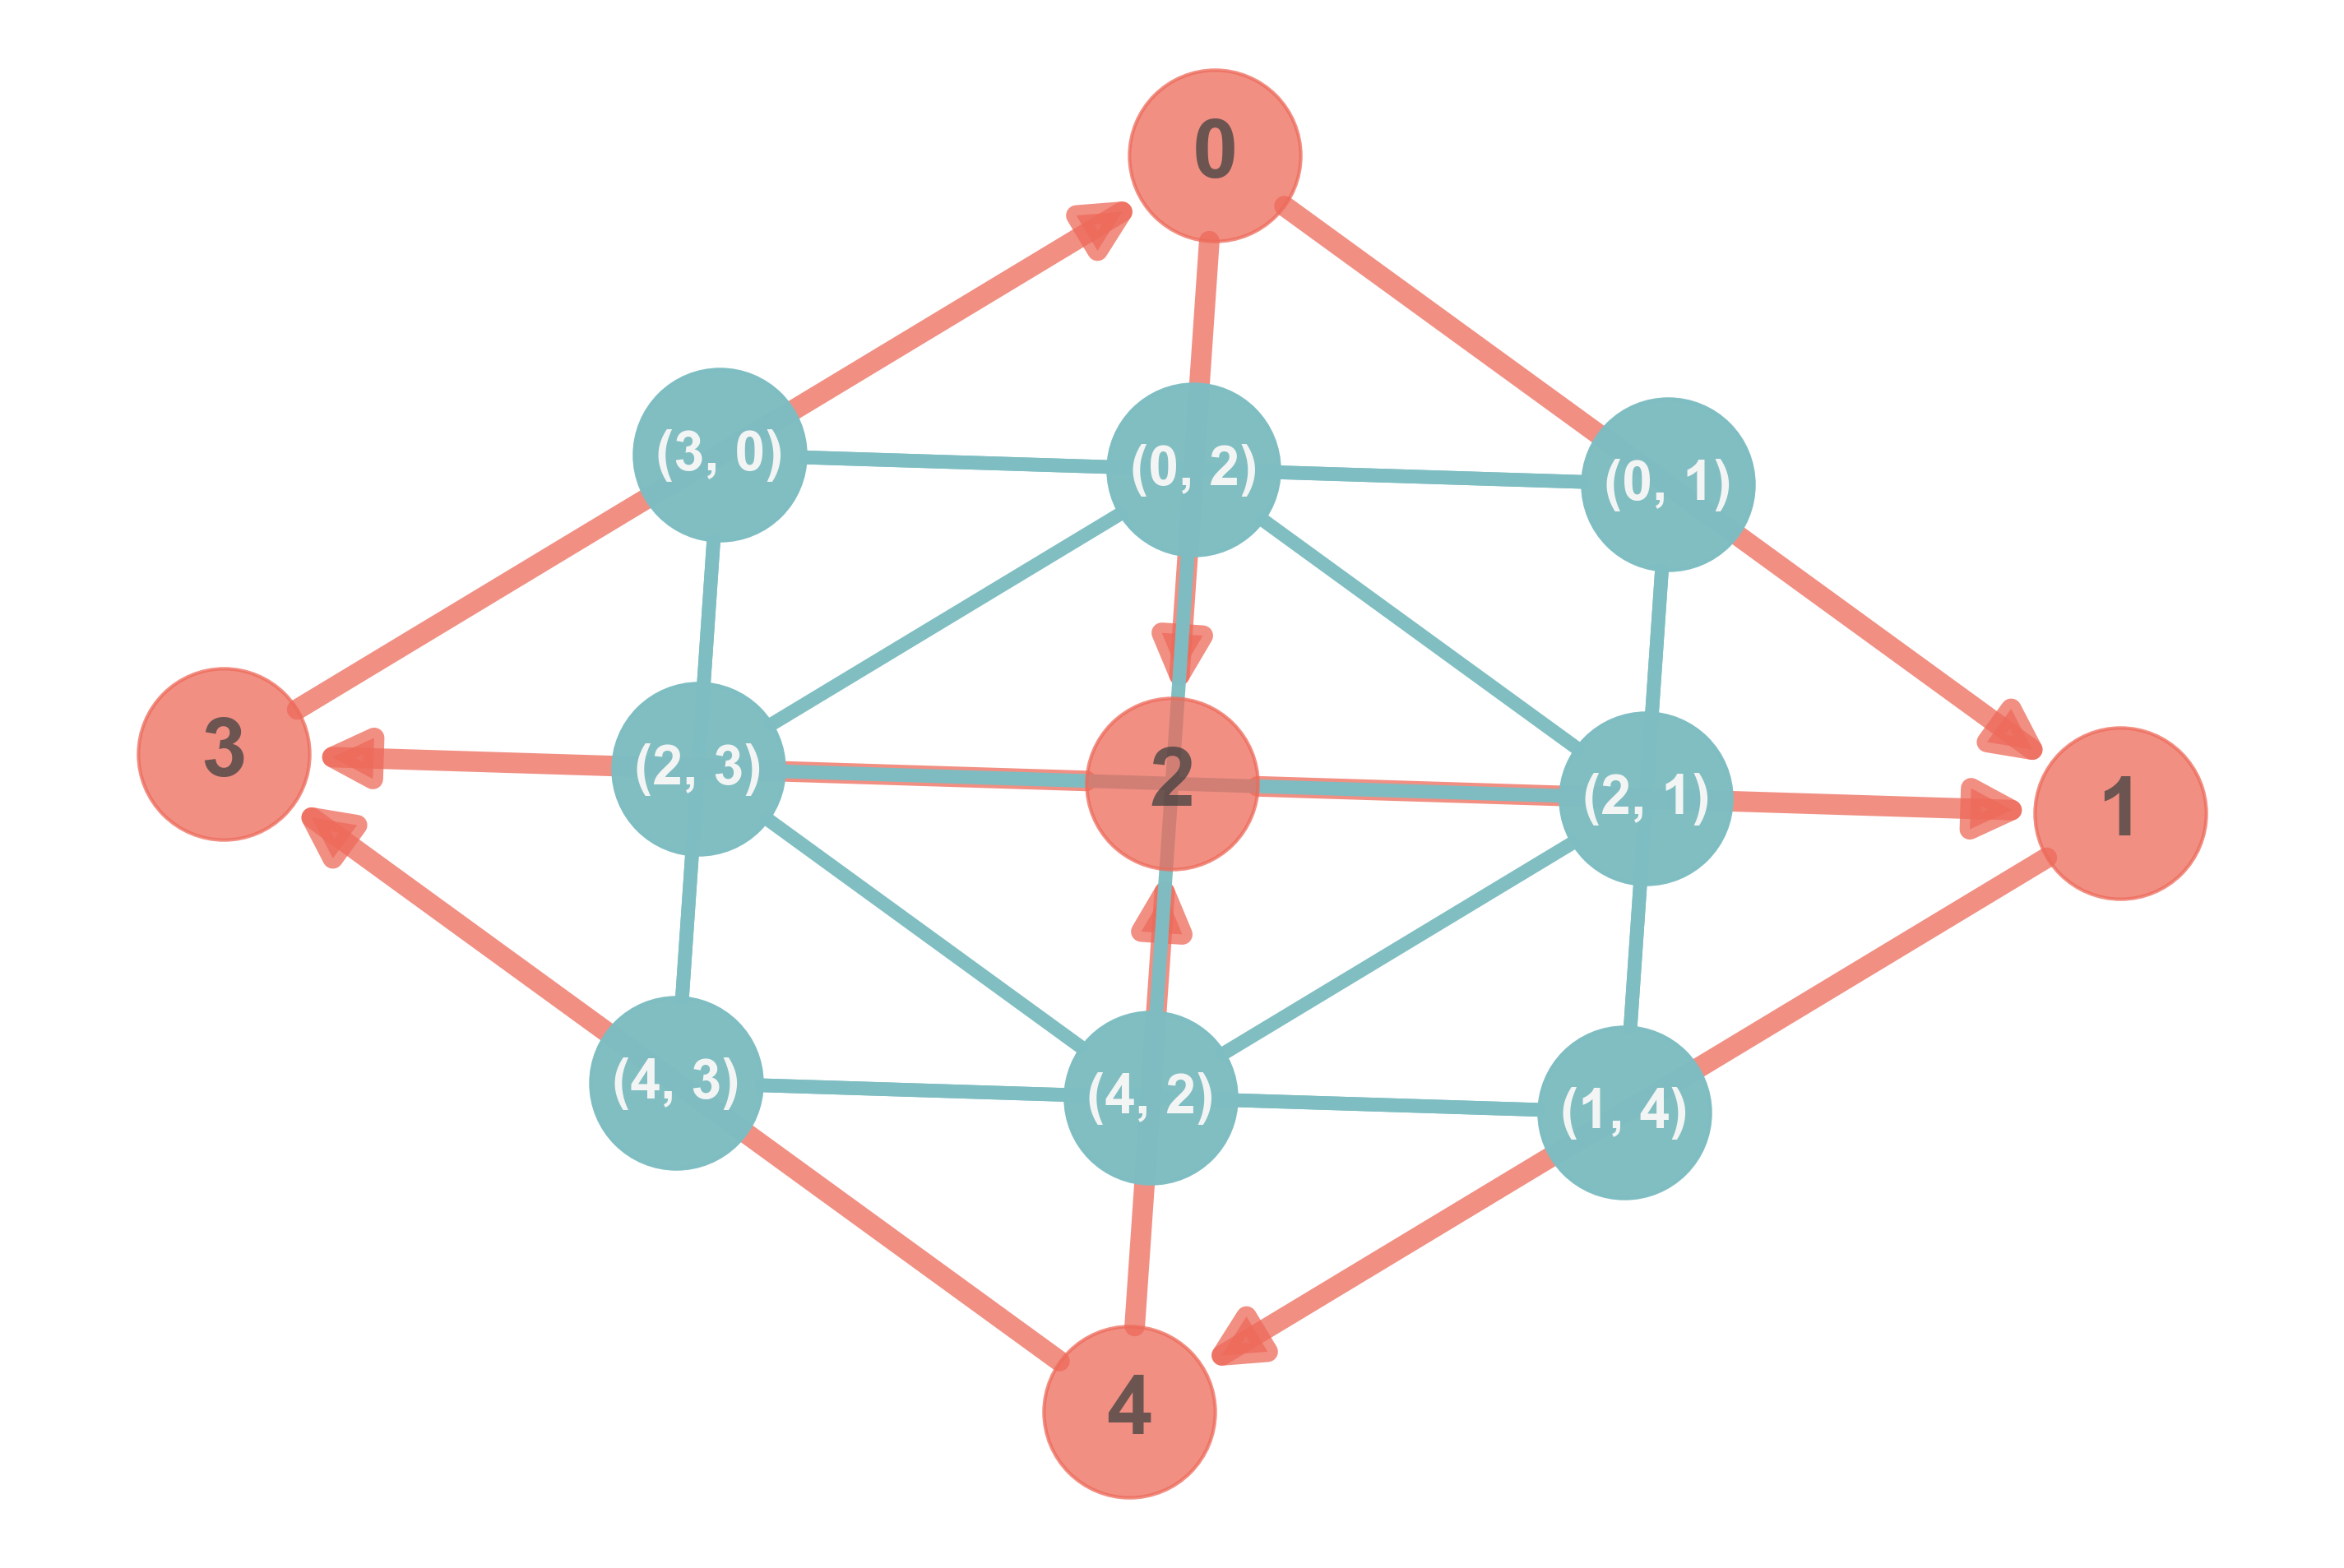

In [2]:
edges = [[0, 1], [0, 2], [3, 0], [2, 1], [2, 3], [1, 4], [4, 2], [4, 3]]

graph = nqx.graph.GraphHandler(edges)

Now, let us take a moment to analyse this graph. As it stands the kinematical Hilbert space is of dimensions
$$
\dim \mathcal{H} = (2 m_{max} + 1)^{\mid E(\gamma)\mid}
$$
where $\mid E(\gamma)\mid = 5$.

We now need to derive a gauge fixing. Since the Gauß constraint ensures charge conservation at every vertex, this can be done by looking at which edges are free to have any value for their charge, and which edges get their charges fixed by other edges. Let us denote by $E_F(\gamma)$ the set of 'free' edges (that is, ones which are not fixed by other edges). For example, at the vertex labeled by 1, the edges [0, 1] and [2, 1] fixe the edge [1, 4]. Similarly, the edges [2, 3] and [4, 3] fixe the edge [3, 0] at the vertex labeled by 3. Doing this for the remaining edges, we see that $\mid E_F(\gamma)\mid = 4$.

Comparing this with the dimensions of the full Hilbert space, we see that the reduction ratio $R$ is
$$
R = \frac{\ln\dim \mathcal{H}^G}{\ln\dim \mathcal{H}} = \frac{\mid E_F(\gamma) \mid}{\mid E(\gamma) \mid}
$$

From which we can read that
$$
\dim \mathcal{H}^G = (\dim \mathcal{H})^R
$$

For our specific case, we see that $R = 0.5$. More explicitly, if we consider the relatively small cutoff $m_{max} = 2$, then $\dim\mathcal{H} = 59.6 \times 10^{15}$ while $\dim\mathcal{H}^G = 244.14 \times 10^{6}$, constituting only $4.096 \times 10^{-7} \%$ of the total Hilbert space!

This reduction of the number of states come with several advantages due to the lower computational cost:
- The graphs considered can be relatively large
- The ability of the network to converge increases
- The convergence statistics become well-behaved (see the Appendix in [this paper](https://arxiv.org/pdf/2402.10622))
- The simulations are drastically quicker (e.g. solving the Euclidean $U(1)^3$ model of LQG with $m_{max} = 1$ on a graph with 8 edges and 500 iterations in the simulation will require around 20 ~ 30 minutes on an HPC, working in the gauge invariant subspace will require around 10 seconds on a standard Apple M1 (2020) chip!)

## 2.1 Defining the gauge invariant Hilbert space

The `Hilbert` class in the `hilbert` module of neuraLQX is capable of implementing gauge invariant Hilbert spaces for any given gauge dimensions. The only thing you need to do is to specify to it the gauge fixing. This is prescribed as a list of lists. In every child list, you specify a list of incoming edges and a list of outgoing edges which fix one another. These should be specified as a tuples representing the edge casted as a string datatype.

In the current graph orientation we see, for example, the following fixing:
- the edge [0, 2] can be fixed by the edges [0, 3] and [0, 1]
- the edge [1, 2] can be fixed by the edges [1, 4] and [0, 1]
- the edge [2, 4] can be fixed by the edges [1, 4] and [3, 4]
- the edge [2, 3] can be fixed by the edges [0, 3] and [3, 4]

Considering the orientation of the edges, we see that for every fixing the charges should sum up as $m_0 = m_1 \oplus -m_2$, where $\oplus$ is the modded addition described in section 1.1 of [this paper](https://arxiv.org/pdf/2402.10622).

Now, let us see how to write a gauge fixing in the language of neuraLQX. The incoming edges should always be composed of one edge, therefore you may need to rewrite some gauge conditions. Therefore, the first gauge condition would be `[['(0, 2)'], ['(0, 3)', '-(0, 1)']]`. The second gauge condition would be `[['(1, 2)'], ['(1, 4)', '-(0, 1)']]`. And so on. You would notice that some of the edges have a minus sign. We explain the notation as follows

- For a gauge condition $m_{e_1} = -m_{e_2} \oplus -m_{e_3} \oplus \cdots \oplus -m_{e_k}$, then use `[['e_1'], ['N', 'e_2, 'e_3', ..., 'e_k']]`. Here, the `'N'` is used to prescribe the modded addition of charges with every charge having a minus sign.
-  For a gauge condition $m_{e_1} = m_{e_2} \oplus -m_{e_3} \oplus m_{e_4} \oplus \cdots \oplus -m_{e_k}$, then use `[['e_1'], ['e_2, '-e_3', 'e_4', ..., '-e_k']]`. Here, specifying a minus sign for one edge will only insert the charge of that edge with a negative value in the modded sum.

All together, the gauge fixing array takes the following form:

In [3]:
constraintArray = [
    [['(0, 2)'], ['(0, 3)', '-(0, 1)']],
    [['(1, 2)'], ['(1, 4)', '-(0, 1)']],
    [['(2, 4)'], ['(1, 4)', '-(3, 4)']],
    [['(2, 3)'], ['(0, 3)', '-(3, 4)']]
]

Now, we create a gauge invariant Hilbert space. We also have to specify the gauge dimensions as well as the cutoff. However, at initialisation we need to instruct it to be gauge invariant and provide it the gauge fixing array. This can be done as

In [4]:
gaugeDims = 3
chargeCutoff = 1

H = nqx.hilbert.Hilbert(graph, chargeCutoff, is_gauge_invariant = True, gauge_fixing = constraintArray, gauge_dimensions = gaugeDims)

And we can see that we have way fewer number of states in the space

In [5]:
H

A gauge invariant Hilbert space with a maximal cut-off of 1 and dimension 531.44 Thousand (10^3) with 9 local degrees of freedom ([-1  0  1])^3 at every edge. The gauge fixing is: [[['(0, 2)'], ['(0, 3)', '-(0, 1)']], [['(1, 2)'], ['(1, 4)', '-(0, 1)']], [['(2, 4)'], ['(1, 4)', '-(3, 4)']], [['(2, 3)'], ['(0, 3)', '-(3, 4)']]].

As a reminder, this is the number of states we would have without working in the gauge invariant subspace!

In [6]:
from neuralqx.utils import parse_number_to_si

parse_number_to_si(((2*chargeCutoff + 1)**8)**3)

'282.43 Billion (10^9)'

## 2.2 Defining the gauge group

Defining the gauge group in the gauge invariant case does not differ from the non-gauge invariant case. Therefore, we can choose the $U(1)$ gauge group simply by

In [7]:
gaugeGroup = nqx.gaugeGroups.U1Gauge(H, gauge_dimensions = gaugeDims)

## 2.3 Defining the gravituational model

We are now ready to create a 3d-Euclidean gravity model in the weak coupling limit. Since we work in the gauge invariant subspace, we can instruct neuralqx to drop the Gauß constraint term from the total master constraint by specifying the appropriate argument:

In [8]:
lqx = nqx.lqx.EuclideanWCL(H, gaugeGroup, spacetime_dims = 3, with_gauge_constraint = False)

Here, the space is rather large to attempt exact diagonalisation. However, we know that the zero eigenspace is the kernel, so we can feed to the model, by hand, this information

In [9]:
lqx.exact_diagonalization(0.0)

╭─────────────────────────────────────────────── neuraLQX Printer ────────────────────────────────────────────────╮
│                                                                                                                 │
│   Message:    Ground-state energy from user determined true value = 0.0                                         │
│   Timestamp:  2024-09-16 06:31:08                                                                               │
│                                                                                                                 │
╰──────────────────────────────── Logged by EuclideanWCL.exact_diagonalization() ─────────────────────────────────╯

We can also check that the states we have are indeed gauge invariant by generating some random states and check if they do obey the gauge fixing

In [10]:
import jax
import numpy as np
from neuralqx.utils import mod_add

# just a function which checks the gauge fixing we wrote above
def checkIfGaugeInv(states):
   return (states[1] == mod_add(states[2], -states[0], chargeCutoff) and
                states[3] == mod_add(states[4], -states[0], chargeCutoff) and
                states[6] == mod_add(states[4], -states[7], chargeCutoff) and
                states[5] == mod_add(states[2], -states[7], chargeCutoff))

Now generate some random basis states, 3 in total:

In [11]:
key = jax.random.PRNGKey(np.random.randint(5000))
states = H.random_state(key, size = 3)
states

Array([[ 1., -1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1., -1.,  0.,  1., -1.,  0., -1.,  0.],
       [ 1.,  0.,  1.,  1., -1., -1.,  0., -1.,  0.,  1.,  1., -1., -1.,
        -1.,  0., -1., -1.,  0., -1.,  0., -1.,  1.,  1.,  1.],
       [ 0., -1., -1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0., -1., -1., -1., -1.,  0.,  0., -1.]],      dtype=float32)

and check if they are gauge invariant

In [12]:
for state in states:
    if checkIfGaugeInv(state[0:8]) and checkIfGaugeInv(state[8:16]) and checkIfGaugeInv(state[16:24]):
        print("State is gauge invariant")

State is gauge invariant
State is gauge invariant
State is gauge invariant


## 2.4 Solving the constraints: neural networks

Solving the quantum constraints using neural networks in neuralqx can be done using the `Solver` module as follows.

In [13]:
solver = nqx.solver.Solver(lqx)

Next, we specify the sampler. NeuraLQX comes with a $U(1)^N$ gauge sampler. This sampler is a Metropolis-Hastings type sampler with a transition kernel which respects the gauge fixing you have specified when creating the Hilbert space. In every transition step, the sampler proposes randomly generated gauge invariant states. The proposed states therefore do not rely on the current states in the sampler. This is done intentionally to avoid getting stuck in some local minima or being biased to certain states in the space. The sampler also comes with a transition kernel which relates the current and proposed states, however, this will be discussed in another tutorial.

When working with gauge invariant Hilbert spaces we **have to** choose the $U(1)^N$ gauge sampler. This is because if we dont, the sampler will suggest states which are outside the space and hence training the network with states which are not gauge invariant!

To choose the $U(1)^N$ gauge invariant sampler, simply use


In [14]:
solver.set_sampler(
    sampler_type = "U1 Gauge Sampler",
    number_of_samples = 250,
    reset_chains = True,
    number_of_chains = 10,
    number_of_sweeps = 10,
    machine_pow = 2
)

╭─────────────────────────────────────────────── neuraLQX Printer ────────────────────────────────────────────────╮
│                                                                                                                 │
│   Message:    Sampler `U1 Gauge Sampler` initialized.                                                           │
│   Timestamp:  2024-09-16 06:31:09                                                                               │
│                                                                                                                 │
╰──────────────────────────────────────── Logged by Solver.set_sampler() ─────────────────────────────────────────╯

Next, we consider the Adaptive Momentum (Adam) optimiser. NeuraLQX also comes with several implementation, such as stochastic gradient descent (SGD), Momentum based descent, and more. We now use the Adam optimiser and specify the learning rate

In [15]:
solver.set_optimizer(optimizer_type = 'Adam', learning_rate = 0.01)

╭─────────────────────────────────────────────── neuraLQX Printer ────────────────────────────────────────────────╮
│                                                                                                                 │
│   Message:    Optimizer `Adam` initialized.                                                                     │
│   Timestamp:  2024-09-16 06:31:09                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────── Logged by Solver.set_optimizer() ────────────────────────────────────────╯

The next step is to specify the network. In the `nn` module of neuralqx, you will find different implementations of neural network architectures provided by neuraLQX. In the following, we use the `RevNet` network.

It is composed of two major blocks: (i) a learning block and (ii) an evaluation block. The learning block is composed of several convolutional sub-blocks (CNNs) each with several layers serving different function. The evaluation block is a simple Feed-Forward network (FFN).

This netwrok is clever in the sense that you need to specify the number of features of the first CNN sub-block and how many such sub-blocks should exist (this will be automated in the future as well!) and it will decide the number of CNN features for every following sub-block. This is done in such a way that the network scales itself to have a number of parameters which is always less than $\dim\mathcal{H}$ while also maintaining high accuracy and good convergence.

We can use this network as follows:

In [16]:
from neuralqx.nn.models import RevNet
import jax

model = RevNet(
        lqx=lqx,
        number_of_cnn_features=12,
        rng_key=jax.random.PRNGKey(0),
)

and now we instruct our solver to use this network

In [17]:
solver.set_network(model)

╭─────────────────────────────────────────────── neuraLQX Printer ────────────────────────────────────────────────╮
│                                                                                                                 │
│   Message:    Network `RevNet` initialized.                                                                     │
│   Timestamp:  2024-09-16 06:31:09                                                                               │
│                                                                                                                 │
╰──────────────────────────────────────── Logged by Solver.set_network() ─────────────────────────────────────────╯

Now we can start the simulation and in the meantime monitor the volume operator squared on the two vertices which are labeled by 0 (a 2-valent vertex) and 2 (a 4-valent vertex)

In [18]:
solver.run(
    number_of_iterations = 500,
    silent_plot = True,
    observables = {
        "V(0)2" : lqx.model.volume_operator_at_vertex(0),
        "V(2)2" : lqx.model.volume_operator_at_vertex(2)
    },
    timer = True
)

  0%|          | 0/500 [00:00<?, ?it/s]

╭────────────────────────────────────────────── Timing Information ───────────────────────────────────────────────╮
│ Total: 11.758                                                                                                   │
│ ├── (57.1%) | MCState.expect_and_grad : 6.718 s                                                                 │
│ │   └── (55.0%) | MCState.sample : 3.693 s                                                                      │
│ │       └── (60.5%) | sampling n_discarded samples : 2.236 s                                                    │
│ ├── (13.9%) | AbstractLinearPreconditioner.__call__ : 1.630 s                                                   │
│ │   ├── (21.1%) | QGTOnTheFly : 0.344 s                                                                         │
│ │   └── (75.3%) | LinearOperator.solve : 1.227 s                                                                │
│ ├── (20.6%) | observables : 2.420 s                                   

╭─────────────────────────────────────────────── neuraLQX Printer ────────────────────────────────────────────────╮
│                                                                                                                 │
│   Message:    State serialised to disc.                                                                         │
│   Timestamp:  2024-09-16 06:31:23                                                                               │
│                                                                                                                 │
╰────────────────────────────────── Logged by Solver._export_serialised_state() ──────────────────────────────────╯

╭───────────────────── neuraLQX Output Log 06:31:23 - 16.09.2024 (S:9e150a-c2f130aad8) 1.0.0 ─────────────────────╮
│                                                                                                                 │
│   Optimization Results:   ╭─────────────────────────────────────────────────────────────────────────────────╮   │
│                           │                                                                                 │   │
│                           │   Exact diagonalization result:          0.0                                    │   │
│                           │   Network result:                        0.000018 ± 0.000019 [σ²=0.000000,      │   │
│                           │                                          R̂=1.0298]                              │   │
│                           │   Accuracy:                              99.99817380374714                      │   │
│                           │   Average min<C> over last 100           0.000(0.000)                           │   │
│                           │   iterations (stddev):                                                          │   │
│                           │   Average R_Hat over last 100            1.020(0.001)                           │   │
│                           │   iterations (stddev):                                                          │   │
│                           │                                                                                 │   │
│                           ╰─────────────────────────────────────────────────────────────────────────────────╯   │
│   Network Configs:        ╭─────────────────────────────────────────────────────────────────────────────────╮   │
│                           │                                                                                 │   │
│                           │   Network type:                     RevNet                                      │   │
│                           │   Number of network parameters:     547                                         │   │
│                           │   number_of_cnn_features:           12                                          │   │
│                           │   lqx:                              'EuclideanWCL'                              │   │
│                           │   rng_key:                          [0 0]                                       │   │
│                           │   is_auto_reg:                      False                                       │   │
│                           │   dropout_rate:                     0.2                                         │   │
│                           │   Params(network) / dim(Hilbert):   0.10292770034679297 %                       │   │
│                           │                                                                                 │   │
│                           ╰─────────────────────────────────────────────────────────────────────────────────╯   │
│   Optimizer Configs:      ╭─────────────────────────────────────────────────────────────────────────────────╮   │
│                           │                                                                                 │   │
│                           │   Optimizer type:         Adam                                                  │   │
│                           │   Learning rate:          0.01                                                  │   │
│                           │   Number of iterations:   500                                                   │   │
│                           │   Diagonal shift:         0.1                                                   │   │
│                           │                                                                                 │   │
│                           ╰─────────────────────────────────────────────────────────────────────────────────╯   │
│   Sampler Configs:        ╭──────────────────────────

╭─────────────────────────────────────────────── neuraLQX Printer ────────────────────────────────────────────────╮
│                                                                                                                 │
│   Message:    NEURALQX LOGGER: Data exported to disc.                                                           │
│   Timestamp:  2024-09-16 06:31:23                                                                               │
│                                                                                                                 │
╰───────────────────────────────────── Logged by Logger.write_log_to_file() ──────────────────────────────────────╯

The simulation has now concluded. Without working the gauge invariant subspace, this same simulation on the HPC would require around 20 minutes! The advantage of using the gauge invariant subspace implementation is that we can do it on a standard Apple M1 chip in roughly 11 seconds!

We can also see the plot of the minimisation process throughout the simulation

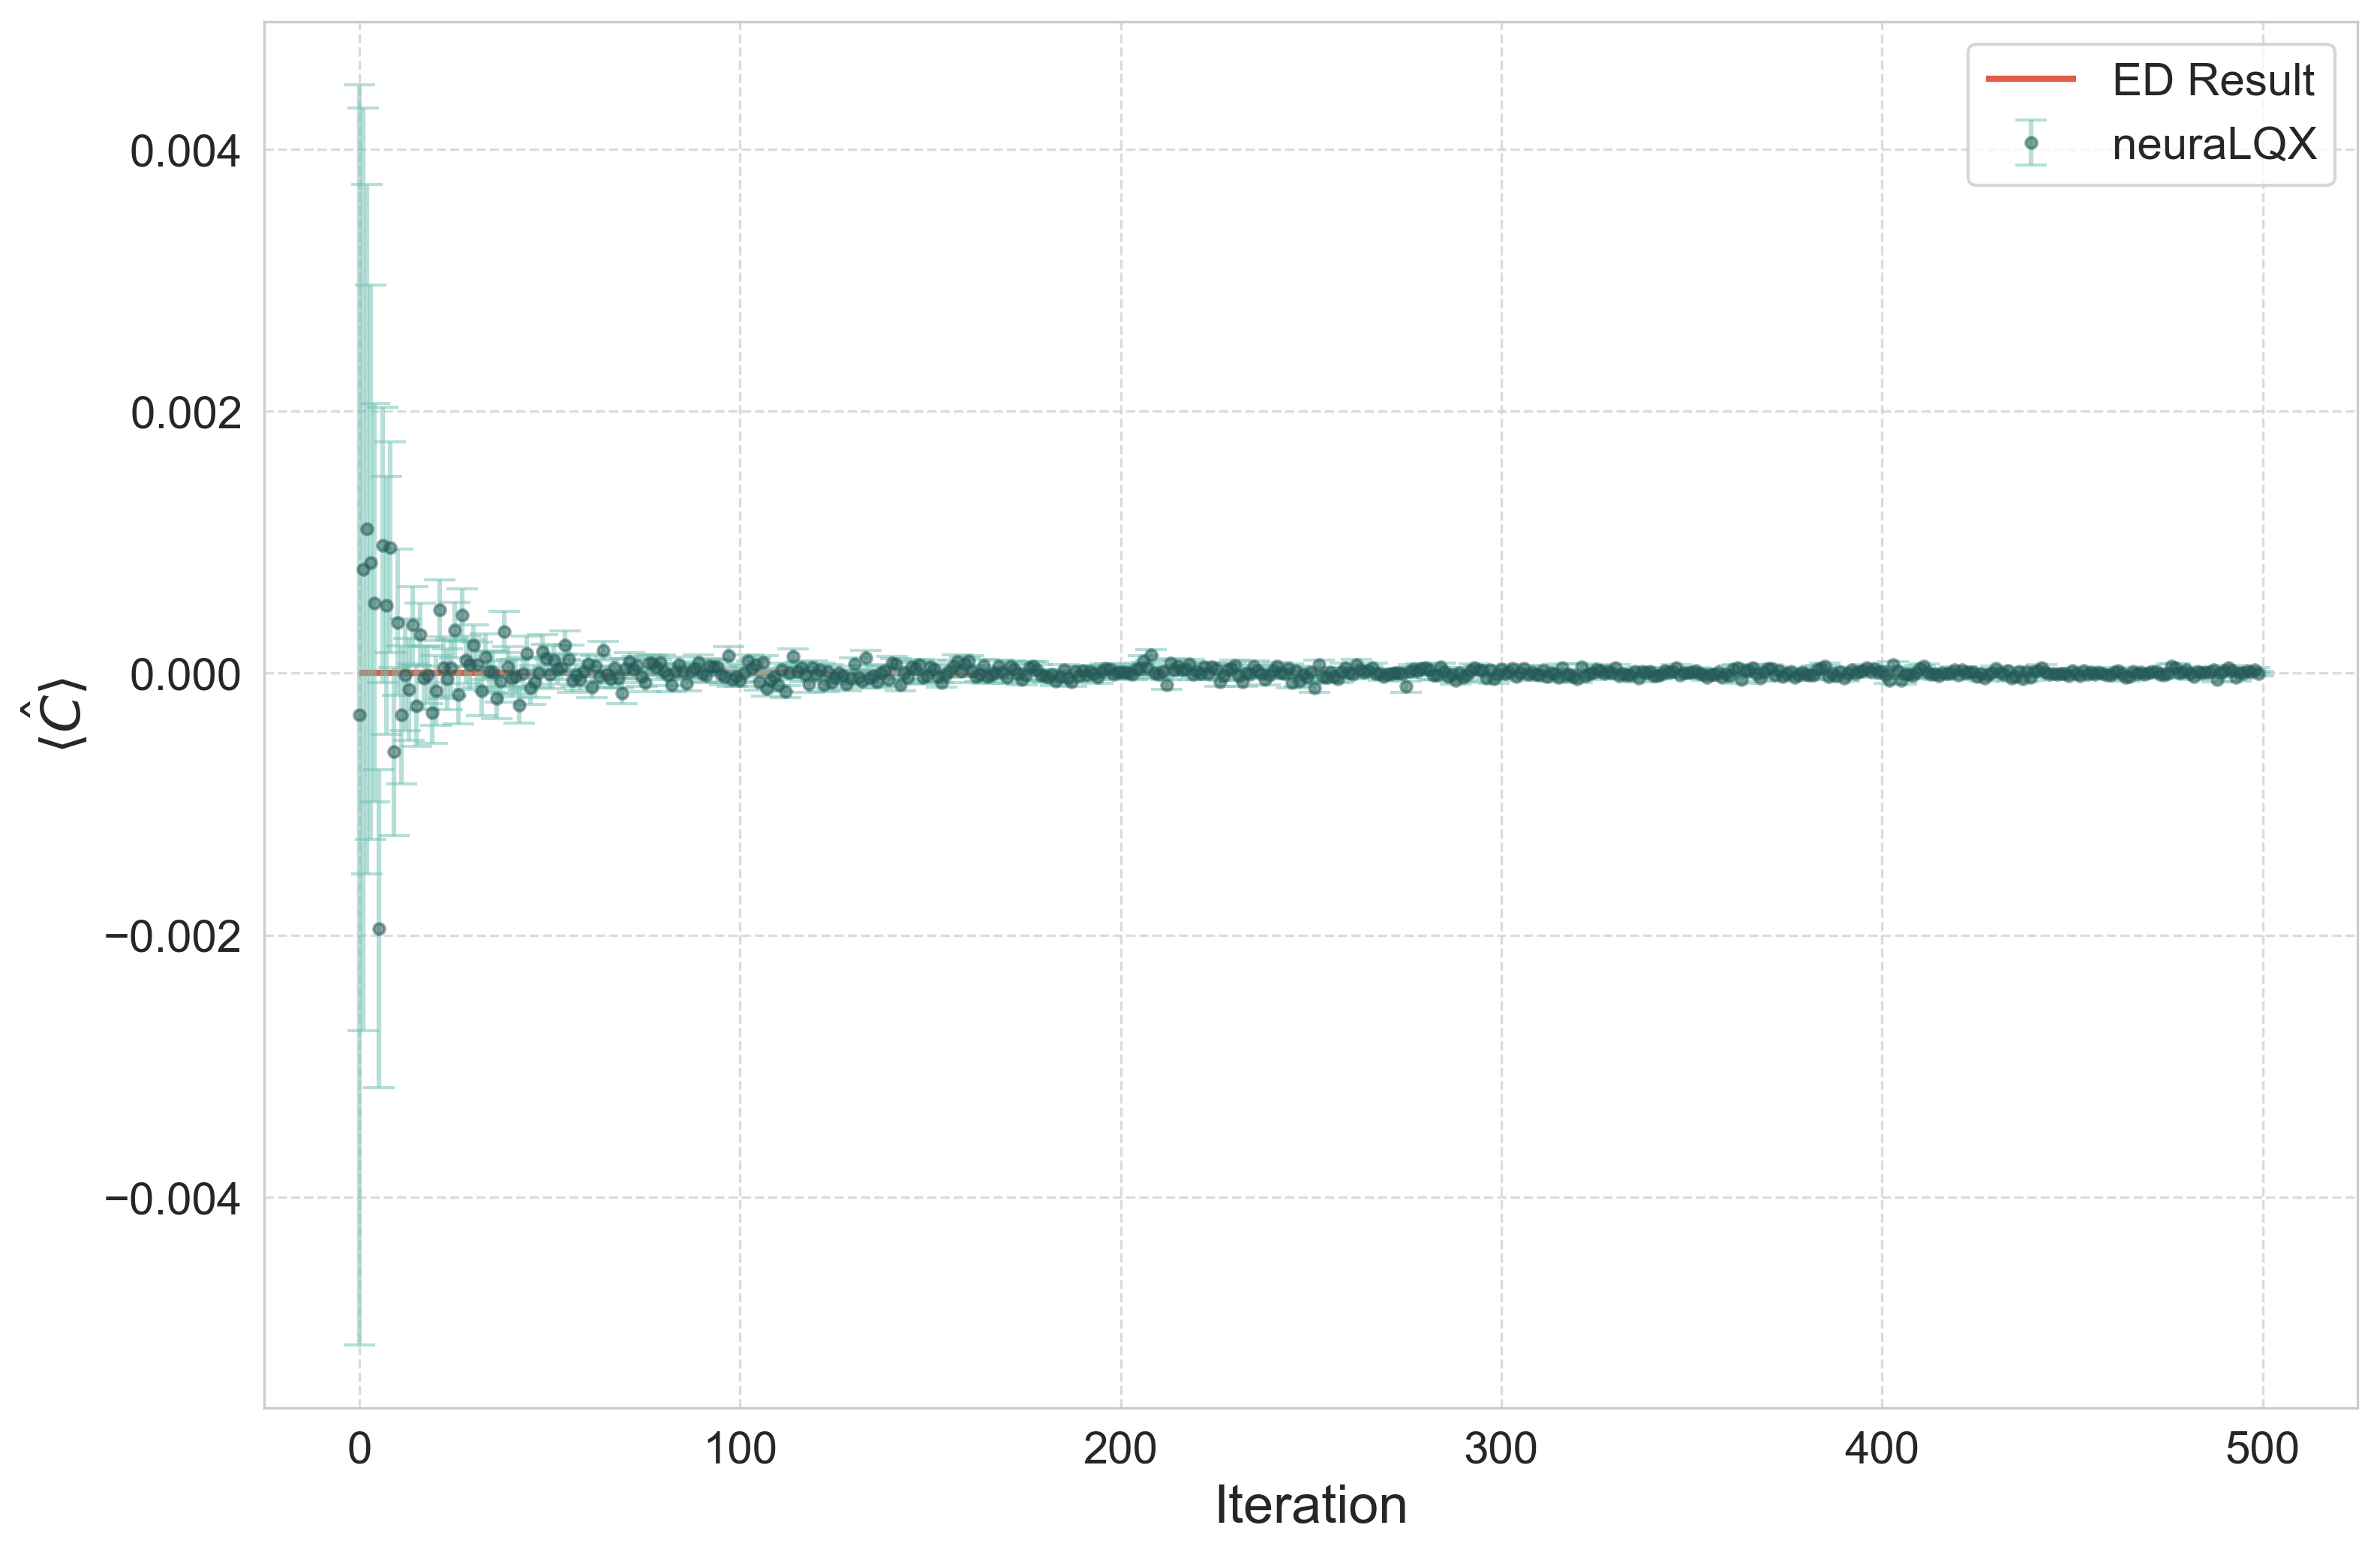

In [19]:
solver.display_plot(with_inset = False)

## 2.5 Physics

Once the simulation is concluded, one can perform some physics. For example, we can check whether the minimal loop holonomies are flat (and hence the solutions we arrive at are genuinely flat solutions). We can also check the quantum fluctuations in the minimal loop holonomies. In this case, expectation values of minimal loop holonomies should close to 3 and quantum fluctuations should be very low.

The `EuclideanWCL` class comes with implementations of the holonomy and minimal loop holonomy operators. And once the simulation is concluded, we have the variational state which can be accessed via `solver.variationalState`. To compute the expectation value, the `variationalState` has a `.expect()` function which does so. Therefore, we can look at the flatness, as well as quantum fluctuations, of every minimal loop in the graph as follows:

### Minimal loop holonomies and quantum fluctuations

In [20]:
for i, minimalCycle in enumerate(graph.minimal_cycles):

    print(f"\n<h(a{i})> = {solver.variational_state.expect(lqx.model.nd_minimal_loop_holonomy(minimalCycle)).mean}")

    h = lqx.model.nd_minimal_loop_holonomy(minimalCycle)
    hAdjoint = lqx.model.nd_minimal_loop_holonomy(minimalCycle, adjoint = 1)

    A = solver.variational_state.expect((h + hAdjoint) * (h + hAdjoint)).mean
    B = solver.variational_state.expect(h + hAdjoint).mean ** 2

    print(f"<(h(a{i}) + h(a{i})†)²> - <h(a{i}) + h(a{i})†>² = {A - B}")
    print()


<h(a0)> = 2.9999999824946917
<(h(a0) + h(a0)†)²> - <h(a0) + h(a0)†>² = 7.585072459903586e-06


<h(a1)> = 2.999998931560702
<(h(a1) + h(a1)†)²> - <h(a1) + h(a1)†>² = 5.878423245064823e-06


<h(a2)> = 2.9999968516804065
<(h(a2) + h(a2)†)²> - <h(a2) + h(a2)†>² = 1.1218056215511751e-05


<h(a3)> = 2.999998191619826
<(h(a3) + h(a3)†)²> - <h(a3) + h(a3)†>² = 5.485424956930274e-06



### Volume

We can also look at the expectation value of the volume operators which we observed during the simulation. As we see, the volume does not necessarily vanish on 3-valent vertices, which is expected from the 3d spatial volume operator of LQG!

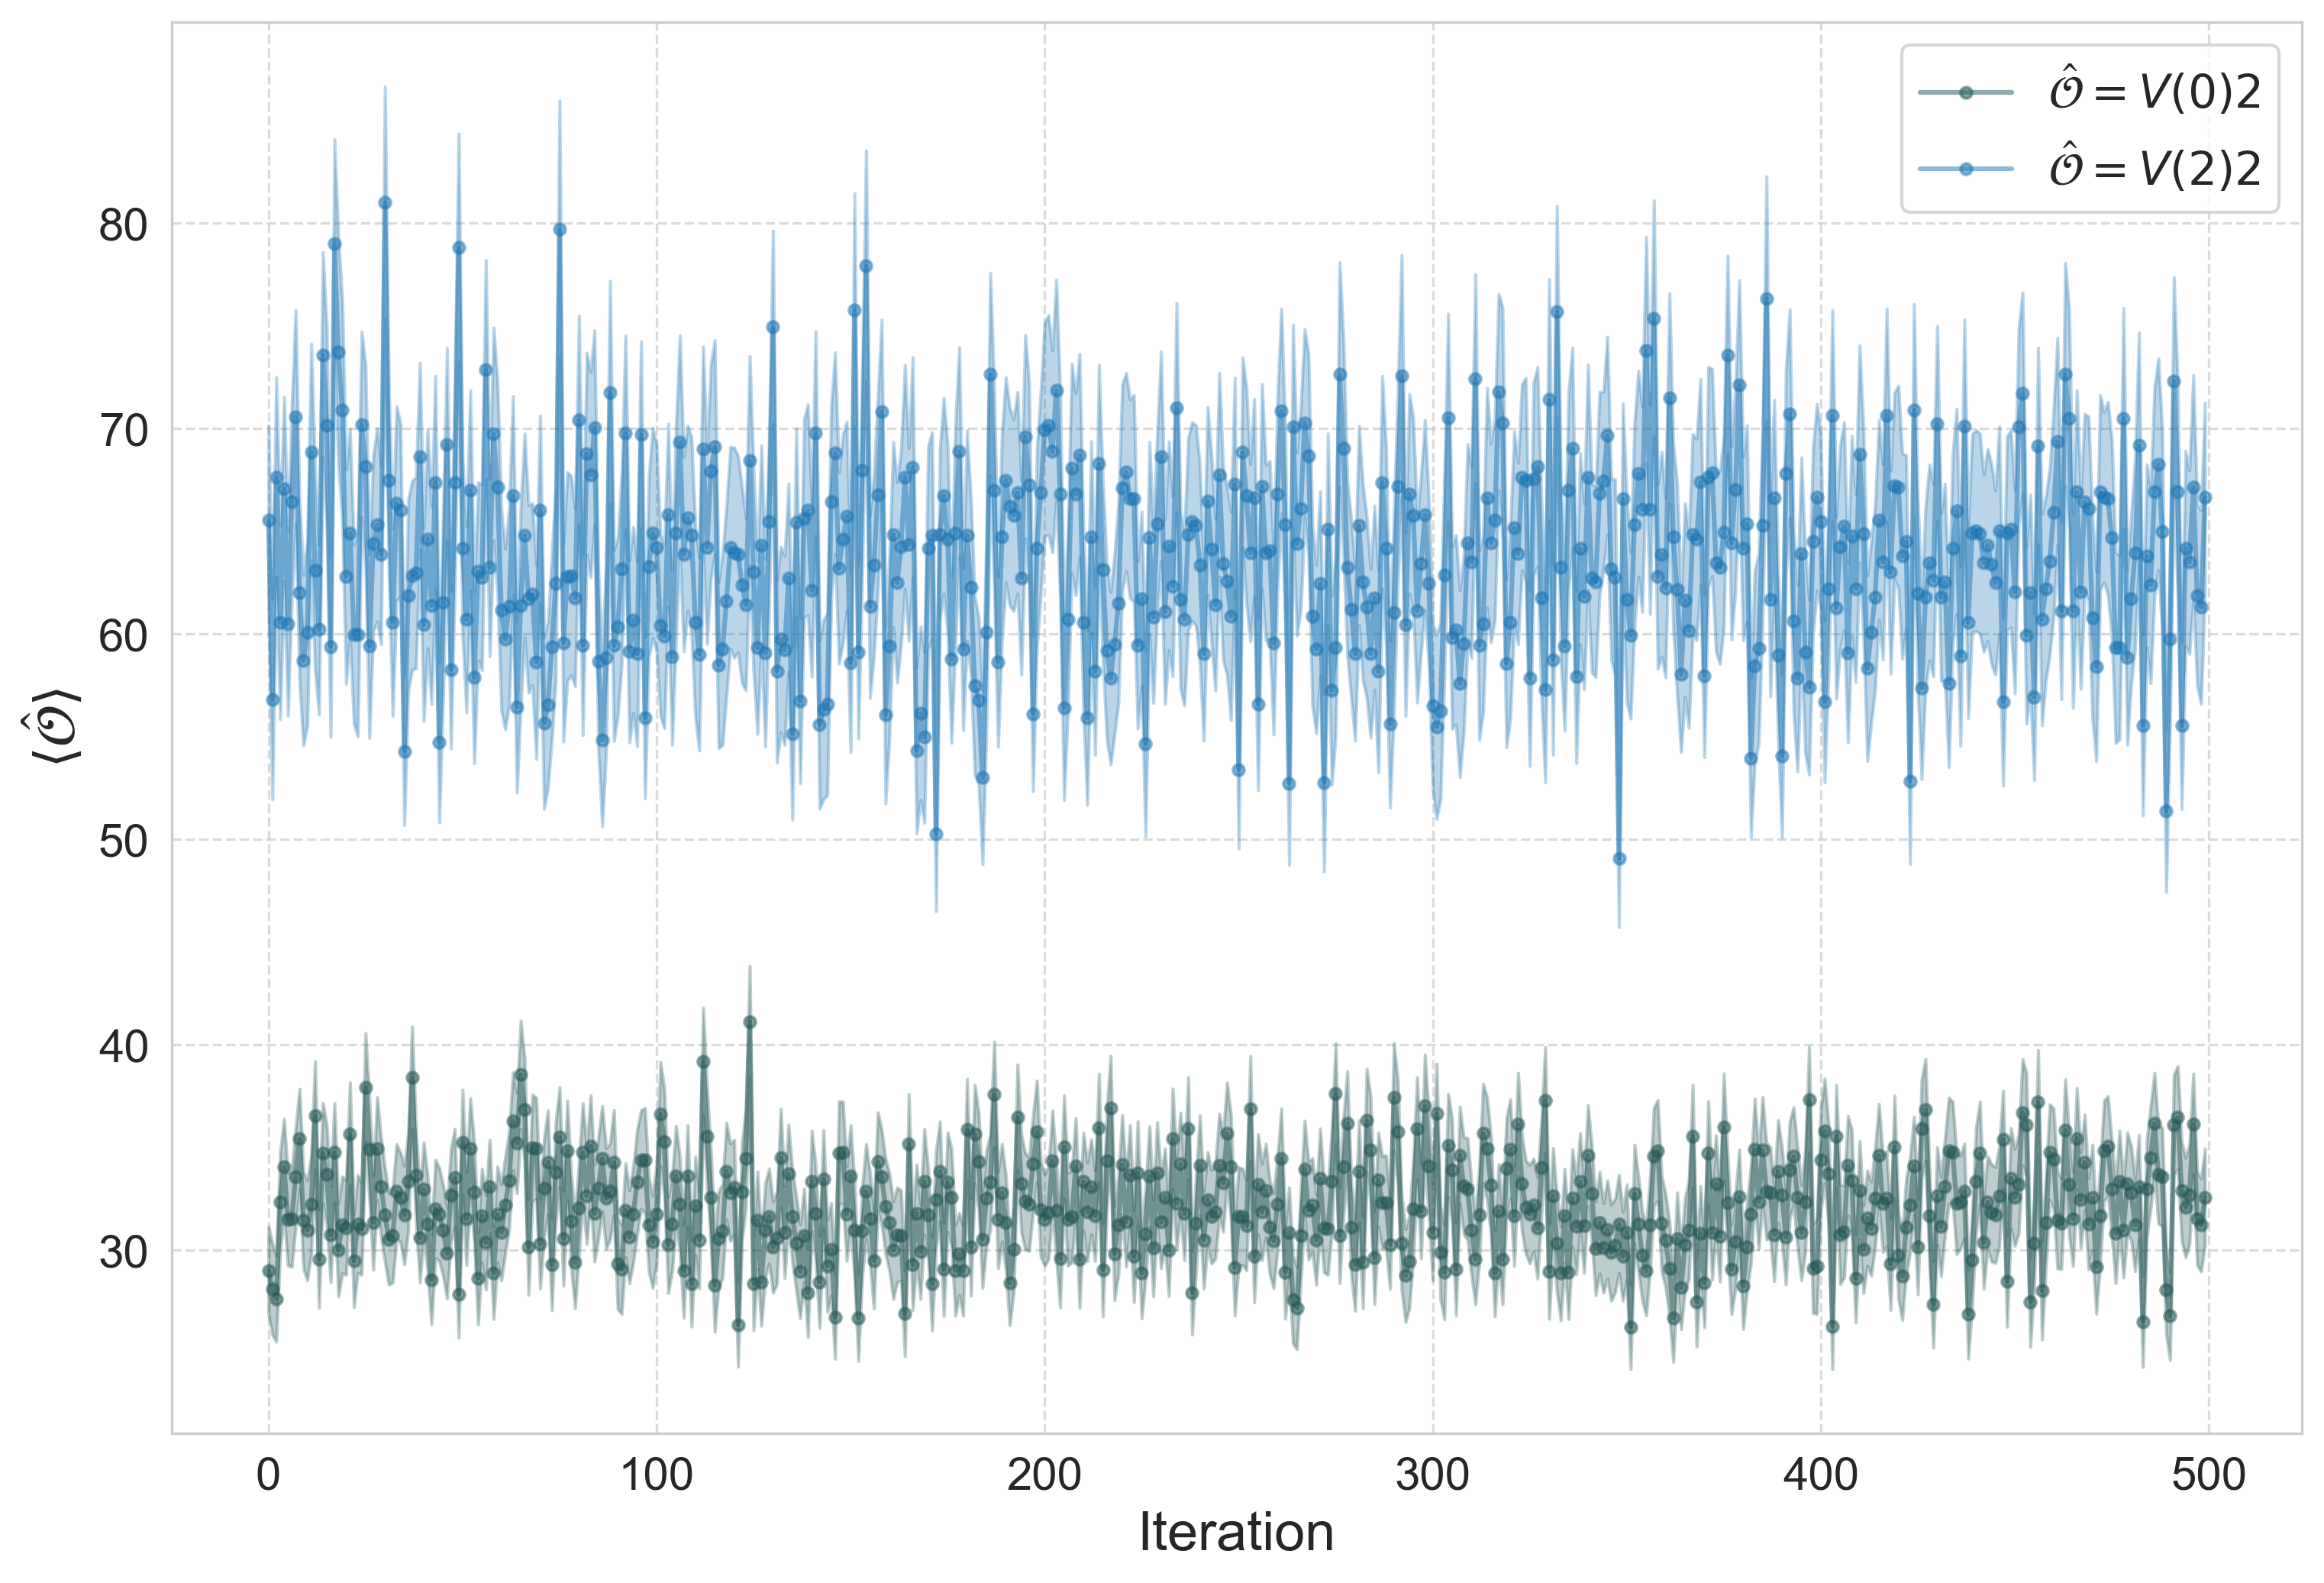

In [21]:
solver.plot_observable("V(0)2", "V(2)2")

### State characterisation

Aside from observables, we can also learn a little bit about the nature of the solutions. For example, one can ask: are the solutions monochromatic? In neuralqx, coloring operators and n-point functions come readily implemented. Therefore, one can study the solutions obtained in many ways.

Let us try to see if the solution is monochromatic. First we need to generate all possible charge vector combinations. This can be done as follows:

In [22]:
from neuralqx.utils import generate_charge_vectors

allStates = generate_charge_vectors(chargeCutoff)

Next, let us compute the coloring operators for all these charge vectors on every edge

In [23]:
allResults = [[] for _ in range(H.hilbert_space._hi.size)]

from neuralqx.operators import coloring

for state in allStates:
    for _ in range(len(allResults)):
        allResults[_].append(float(solver.variational_state.expect(coloring(H, _, state)).mean))


And now we can see if the state is monochromatic!

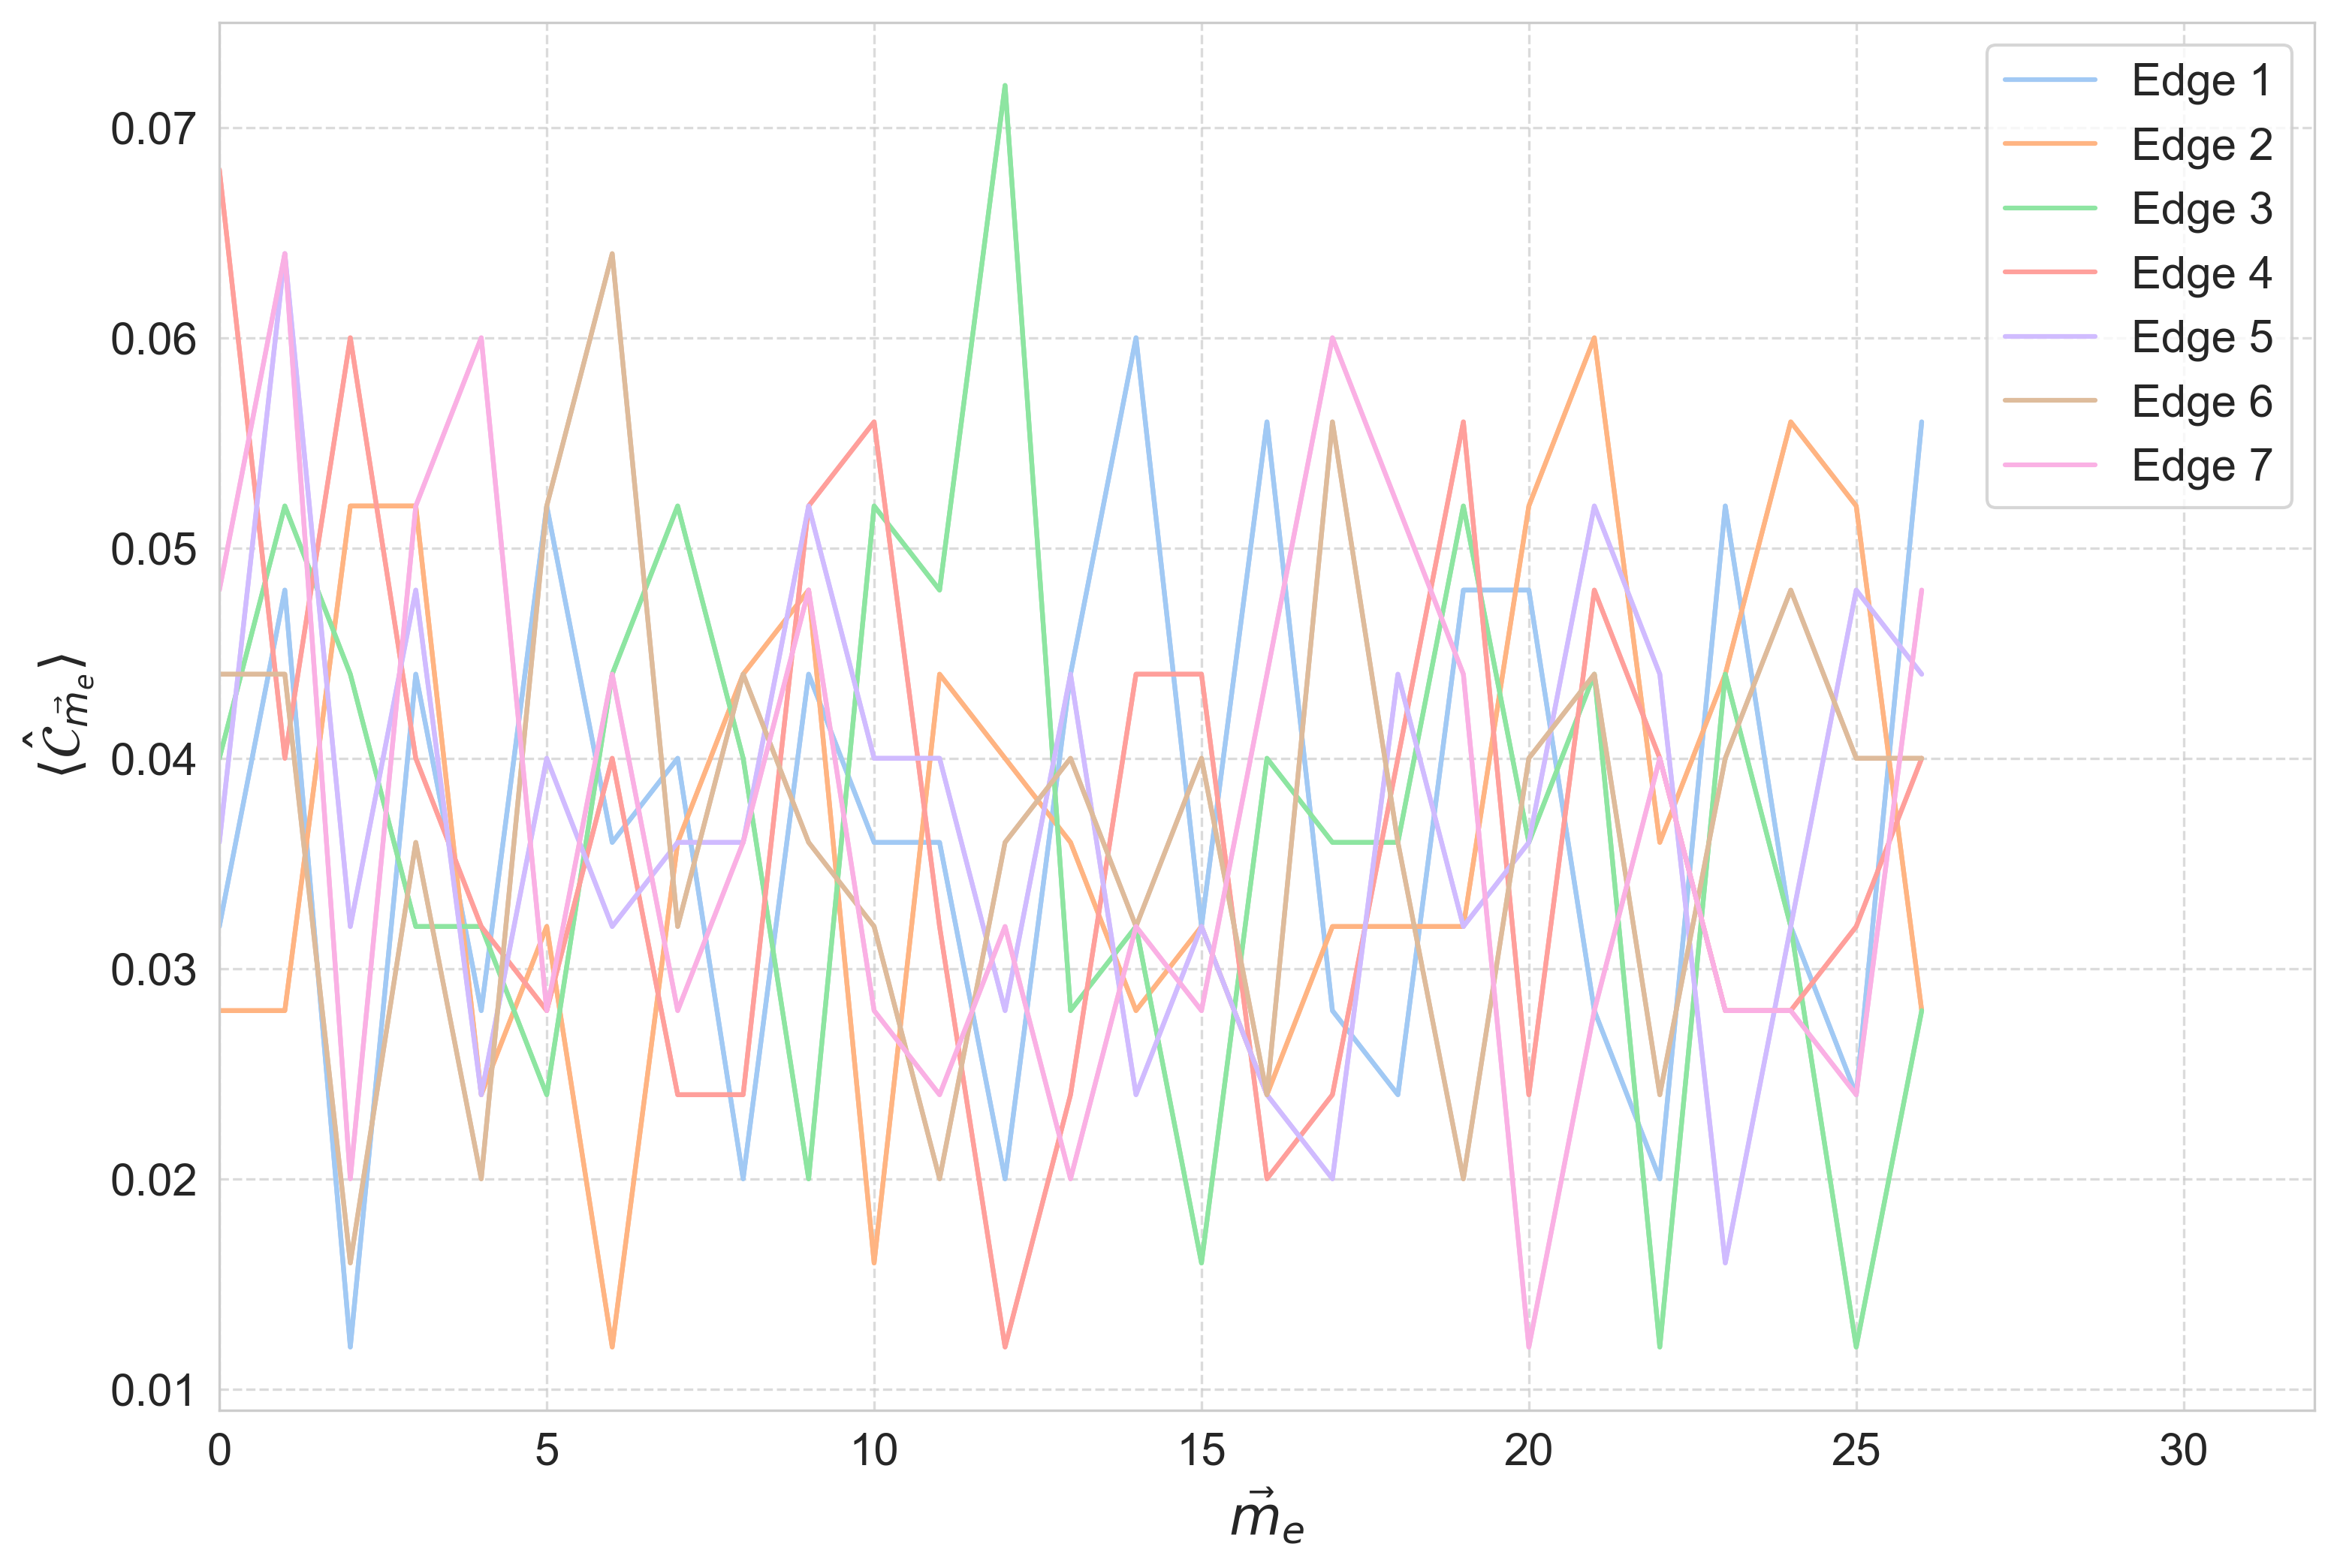

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = [f'Edge {i+1}' for i in range(7)]

plt.figure(figsize=(12, 8), dpi=300)

colors = sns.color_palette("pastel", 7)

for idx in range(7):
    plt.plot(allResults[idx], label=f"Edge {idx + 1}", color=colors[idx], linestyle='-', alpha=0.99, linewidth=1.5)
    plt.plot(allResults[idx], color=colors[idx], linestyle='-', alpha=0.99, linewidth=1.5)

plt.xlim(0, len(allStates) + 5)

plt.xlabel(r'$\vec{m}_{e}$', fontsize='xx-large')
plt.ylabel(r'$\langle \hat{\mathcal{C}}_{\vec{m}_{e}} \rangle$', fontsize='xx-large')

plt.tick_params(axis="both", which="both", labelsize="x-large")

plt.legend(fontsize="x-large")

plt.grid(True, linestyle="--", alpha=0.7)

plt.show()


Another thing we can look at is the expectation value of the 2-point function of the coloring operator. For this, we can choose some set of specific charge vectors and look at the 2-point function between different edges for the coloring operators acting on the first edge with the first charge vector and the second edge with the second charge vector.

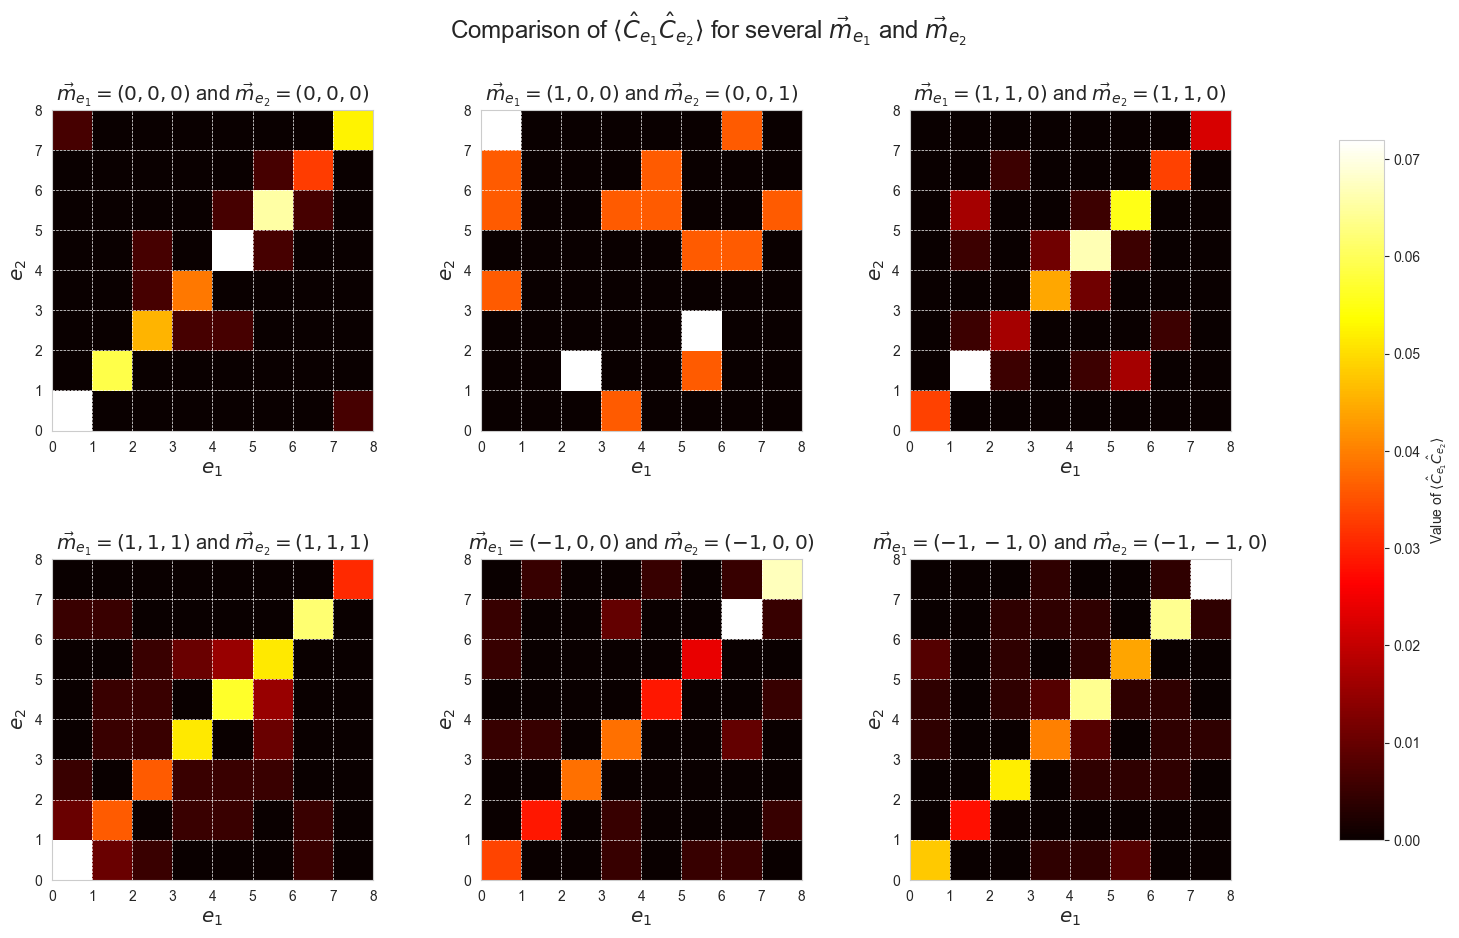

In [25]:
from neuralqx.operators import n_point_function
import numpy as np
import matplotlib.pyplot as plt

# the labels for the edges
e1_values = range(8)
e2_values = range(8)

# choose some charge vectors
state1_list = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (-1, 0, 0), (-1, -1, 0)]
state2_list = [(0, 0, 0), (0, 0, 1), (1, 1, 0), (1, 1, 1), (-1, 0, 0), (-1, -1, 0)]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# compute the expectation values for every pair of charge vectors and for every
# possible edge combination
for idx, (state1, state2) in enumerate(zip(state1_list, state2_list)):
    heatmap_values = np.zeros((8, 8))
    for i, e1 in enumerate(e1_values):
        for j, e2 in enumerate(e2_values):
            heatmap_values[i, j] = solver.variational_state.expect(
                n_point_function(H, coloring, (e1, e2), (state1, state2))
            ).mean

    ax = axes[idx // 3, idx % 3]

    im = ax.imshow(heatmap_values, cmap='hot', origin='lower', extent=[0, 8, 0, 8], vmin=0)

    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)
    ax.set_xlabel(r'$e_1$', fontsize='x-large')
    ax.set_ylabel(r'$e_2$', fontsize='x-large')
    ax.set_title(rf'$\vec{{m}}_{{e_1}} = {state1}$ and $\vec{{m}}_{{e_2}} = {state2}$', fontsize='x-large')

# plotting
fig.subplots_adjust(right=0.8, hspace=0.4)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax, label=r'Value of $\langle \hat{{C}}_{{e_1}} \hat{{C}}_{{e_2}}\rangle$')

plt.suptitle(fr'Comparison of $\langle \hat{{C}}_{{e_1}} \hat{{C}}_{{e_2}}\rangle$ for several $\vec{{m}}_{{e_1}}$ and $\vec{{m}}_{{e_2}}$', fontsize='xx-large')

plt.show()
